# Predicción de fallo cardíaco


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

Lectura del fichero


In [32]:
heart_data = pd.read_csv('datasets/heart.csv')
heart_data.shape

(918, 12)

1. Preprocesado de los datos


- Comprobación de valores nulos


In [33]:
heart_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

- Transformación de variables categóricas a numéricas


In [34]:
heart_data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [35]:
label_encoder = LabelEncoder()
for x in heart_data.columns:
    if heart_data[x].dtype == 'object':
        heart_data[x] = label_encoder.fit_transform(heart_data[x])
heart_data.dtypes

Age                 int64
Sex                 int64
ChestPainType       int64
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG          int64
MaxHR               int64
ExerciseAngina      int64
Oldpeak           float64
ST_Slope            int64
HeartDisease        int64
dtype: object

In [36]:
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


- Comprobación de balanceo


In [37]:
X = heart_data.drop('HeartDisease', axis=1)
y = heart_data['HeartDisease']

y.value_counts(normalize=True) * 100

HeartDisease
1    55.337691
0    44.662309
Name: proportion, dtype: float64

- Estandarizado de datos


In [38]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(heart_data.drop('HeartDisease', axis=1))

2. Selección de modelos


In [48]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision_Tree': DecisionTreeClassifier(max_depth=3),
    'Random_Forest': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'Naive_Bayes': GaussianNB()
}

3. Entrenamiento y validación de modelos


In [49]:
X = scaled_data
y = heart_data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scores = {}

for name, model in models.items():
    scores[name] = cross_val_score(model, X, y, scoring='accuracy')
    print(f'{name}: Average Accuracy={np.mean(scores[name]):.4f}')

KNN: Average Accuracy=0.8256
Decision_Tree: Average Accuracy=0.8158
Random_Forest: Average Accuracy=0.8191
SVC: Average Accuracy=0.8256
Naive_Bayes: Average Accuracy=0.8311


4. Evaluación y comparación de modelos (recall en 0 es TNR y en 1 es el TPR)


In [50]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = cross_val_predict(model, X, y, cv=5)
    print(f'----- {name} -----')
    print(f'Average Accuracy: {np.mean(scores[name]):.4f}')
    print(
        f'AUC (Cross-validated): {np.mean(cross_val_score(model, X, y, scoring="roc_auc")):.4f}')
    if name == 'Decision_Tree':
        print(f'Maximum depth: {model.get_depth()}')
        print(f'Number of nodes: {model.tree_.node_count}')
        print(f'Number of leaf nodes: {model.get_n_leaves()}')
    print(classification_report(y, y_pred))

----- KNN -----
Average Accuracy: 0.8256
AUC (Cross-validated): 0.8815
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       410
           1       0.86      0.82      0.84       508

    accuracy                           0.83       918
   macro avg       0.82      0.83      0.82       918
weighted avg       0.83      0.83      0.83       918

----- Decision_Tree -----
Average Accuracy: 0.8158
AUC (Cross-validated): 0.8517
Maximum depth: 3
Number of nodes: 15
Number of leaf nodes: 8
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       410
           1       0.81      0.86      0.84       508

    accuracy                           0.82       918
   macro avg       0.82      0.81      0.81       918
weighted avg       0.82      0.82      0.82       918

----- Random_Forest -----
Average Accuracy: 0.8191
AUC (Cross-validated): 0.9095
              precision    recall  f1-score   suppor

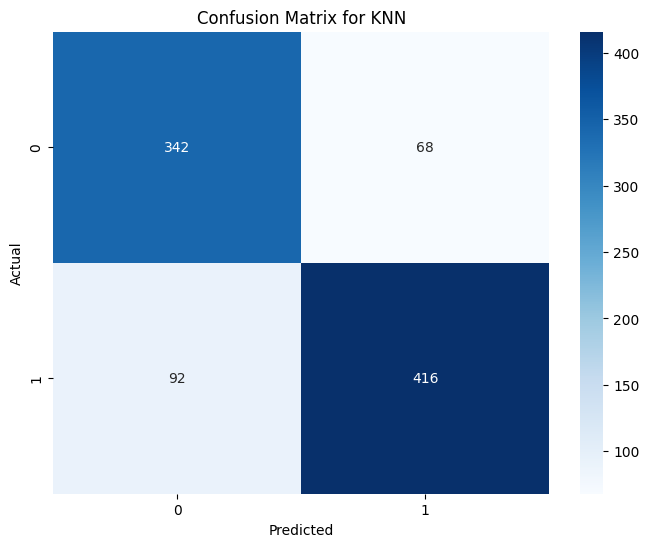

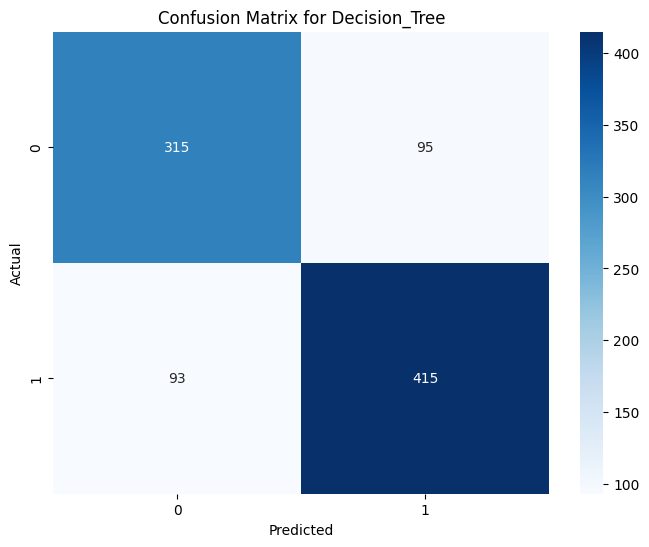

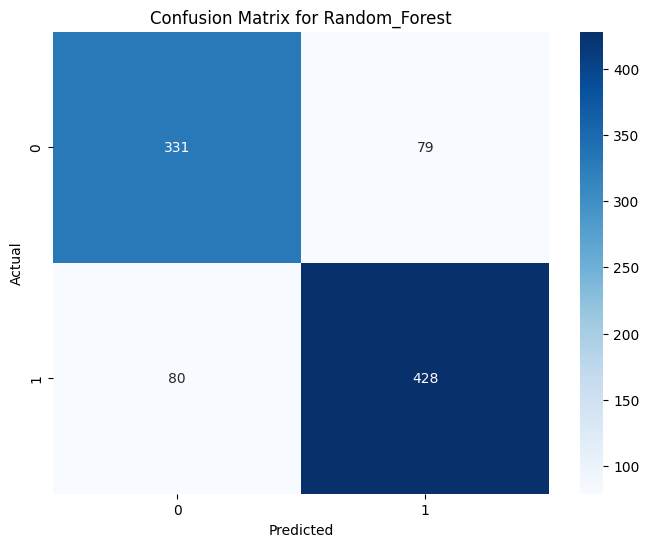

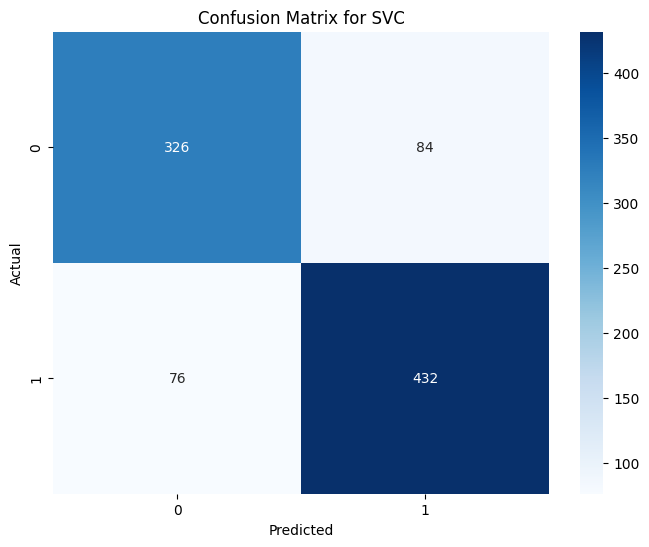

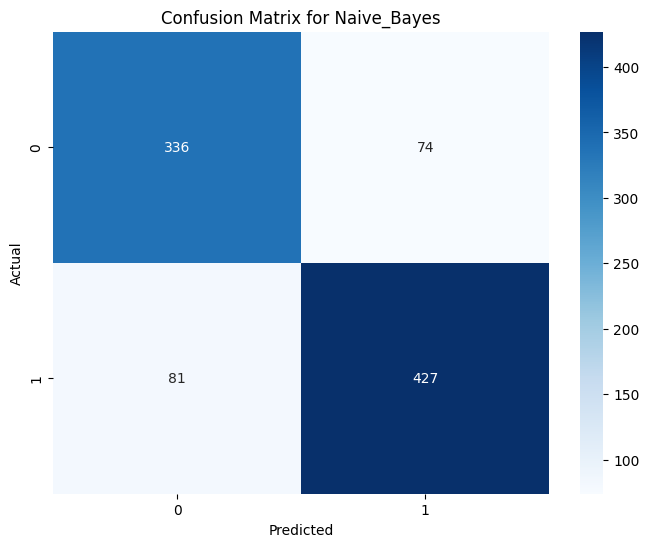

In [42]:
for name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=5)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

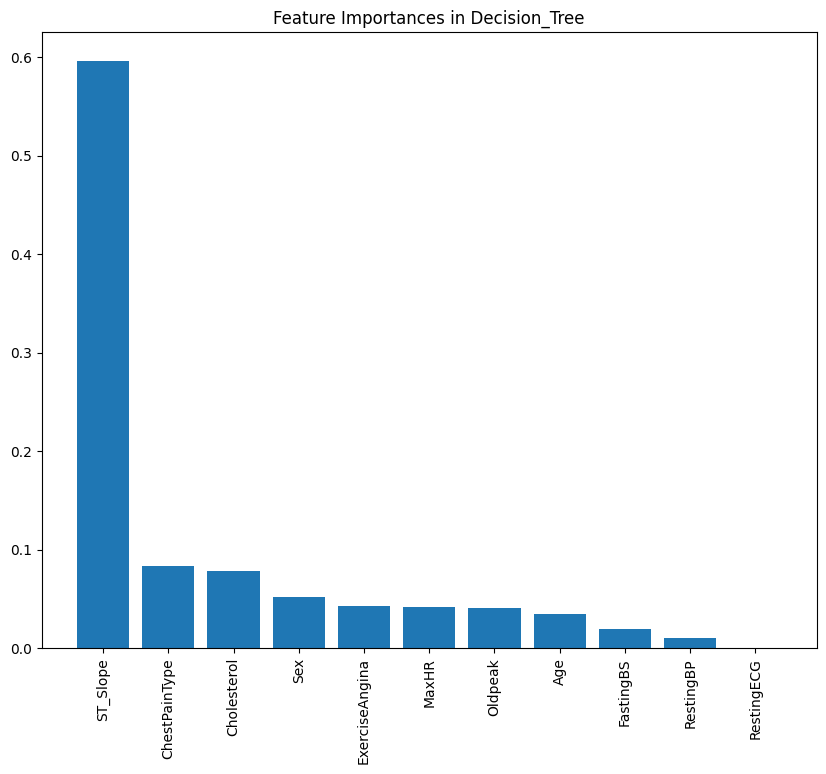

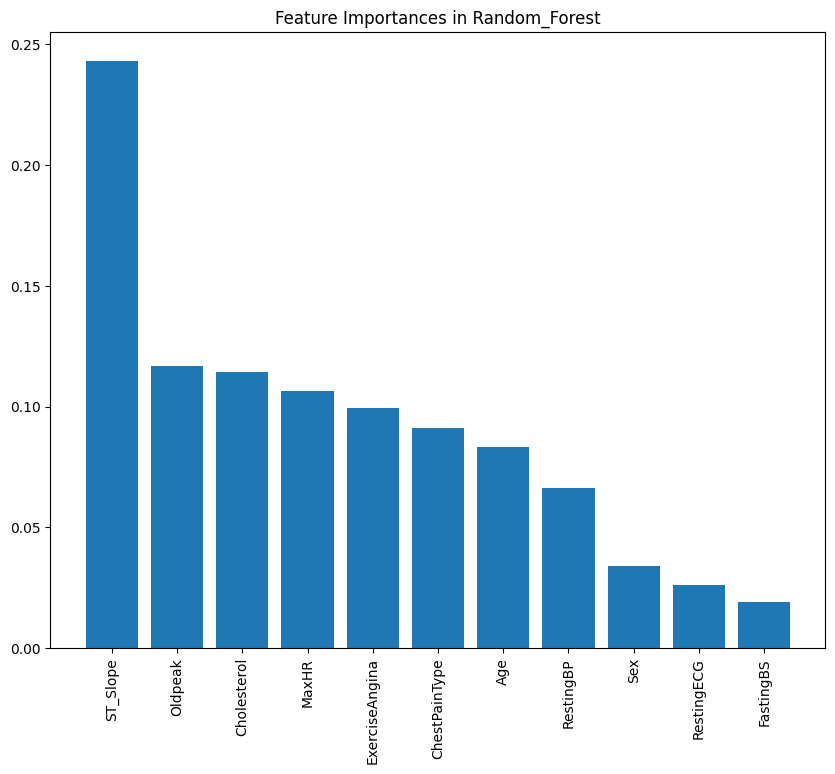

In [43]:
def importances(model_name):
    plt.figure(figsize=(10, 8))
    importance = models[model_name].feature_importances_
    indexed_importances = np.argsort(importance)[::-1]
    plt.title('Feature Importances in ' + model_name)
    plt.bar(range(X_train.shape[1]), importance[indexed_importances])
    plt.xticks(range(X_train.shape[1]),
               heart_data.columns[indexed_importances], rotation=90)

    plt.show()


if 'Decision_Tree' in models:
    importances('Decision_Tree')

if 'Random_Forest' in models:
    importances('Random_Forest')

In [44]:
# plt.figure(figsize=(10, 8))

# for name, model in models.items():
#    model.fit(X_train, y_train)
#
#    y_prob = model.predict_proba(X_test)[:, 1]
#
#    fpr, tpr, _ = roc_curve(y_test, y_prob)
#    roc_auc = auc(fpr, tpr)
#
#    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')
# plt.show()

Curva ROC y AUC


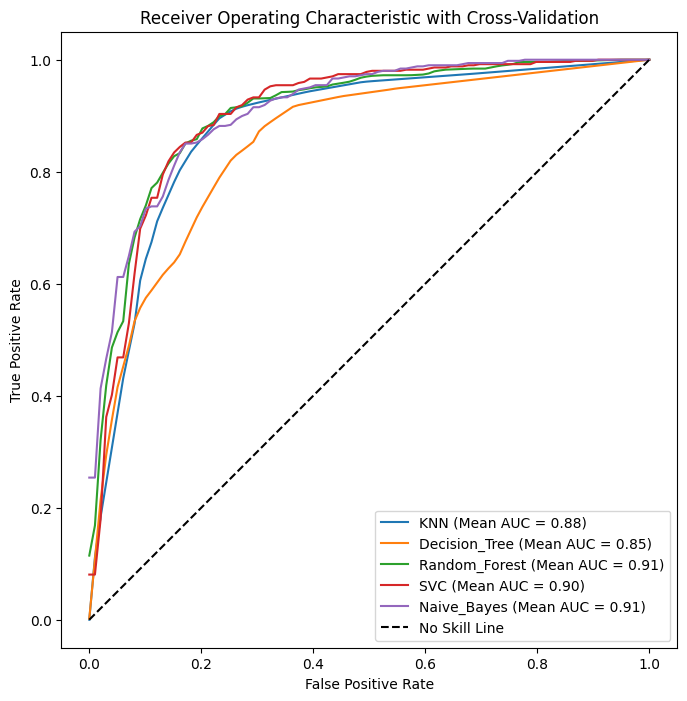

In [51]:
# Define the number of folds for cross-validation
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds)

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 8))
# plt.figure(figsize=(10, 8))

# Iterate over models
for name, model in models.items():
    # Initialize variables to store results
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = 0.0

    # Iterate over each fold
    for train_index, test_index in cv.split(X, y):
        # Split data
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Get predicted probabilities
        y_prob_fold = model.predict_proba(X_test_fold)[:, 1]

        # Compute ROC curve and AUC for this fold
        fpr, tpr, _ = roc_curve(y_test_fold, y_prob_fold)
        mean_tpr += np.interp(mean_fpr, fpr, tpr)

    # Calculate mean TPR for all folds
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Plot

    plt.plot(mean_fpr, mean_tpr, label=f'{name} (Mean AUC = {mean_auc:.2f})')

# Plot baseline
ax.plot([0, 1], [0, 1], 'k--', label='No Skill Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic with Cross-Validation')
ax.legend(loc='lower right')
ax.axis('square')
plt.show()

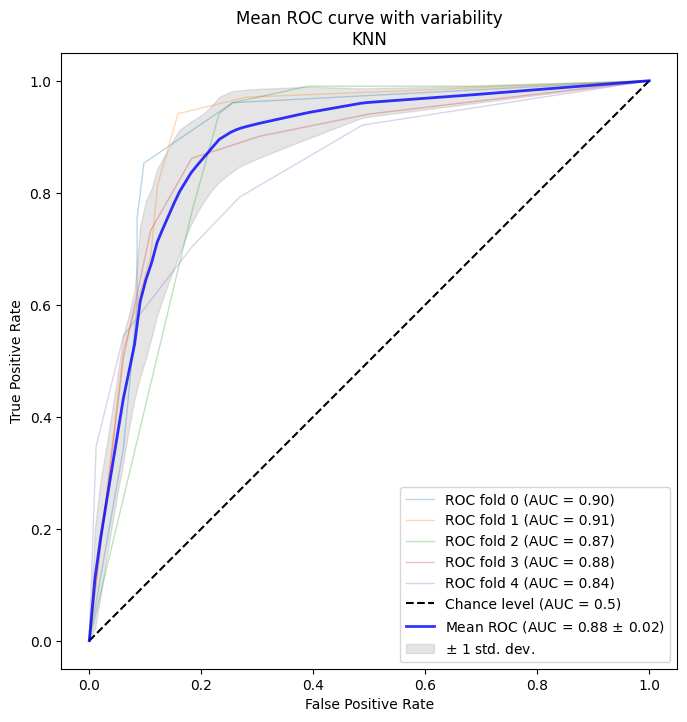

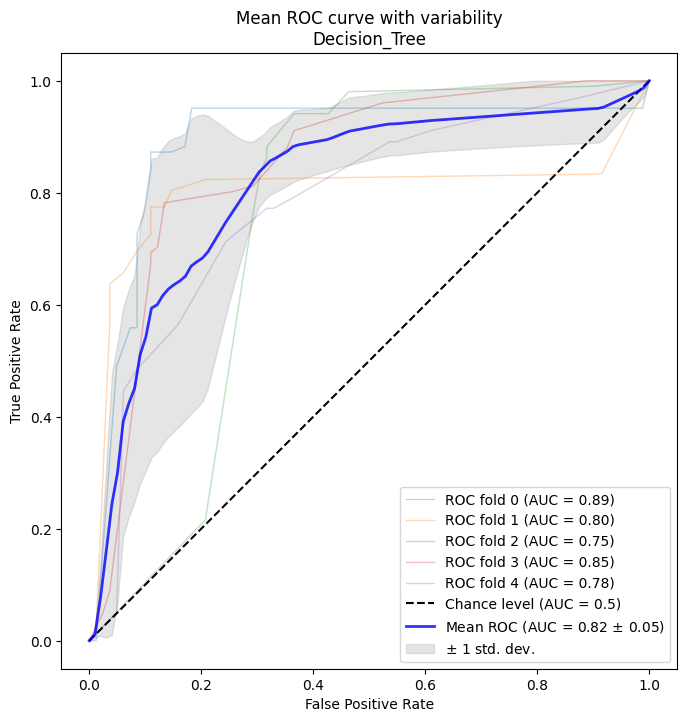

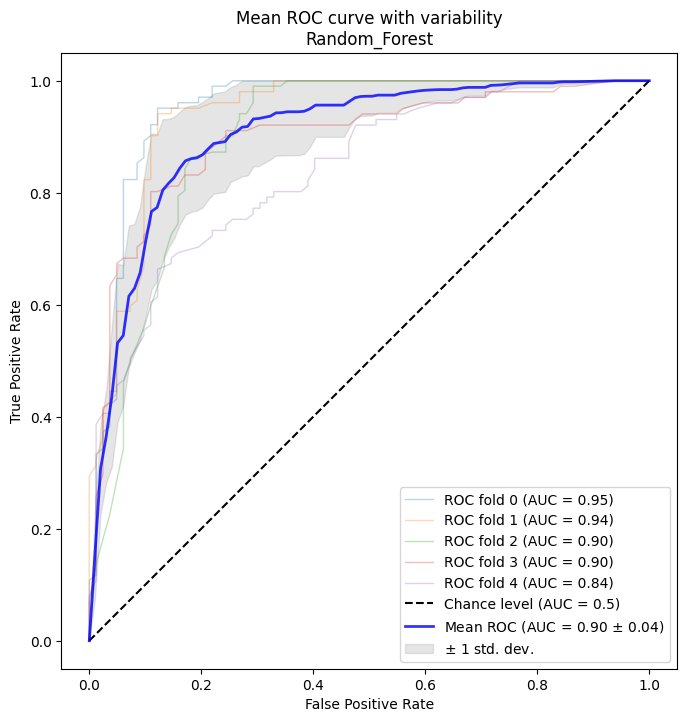

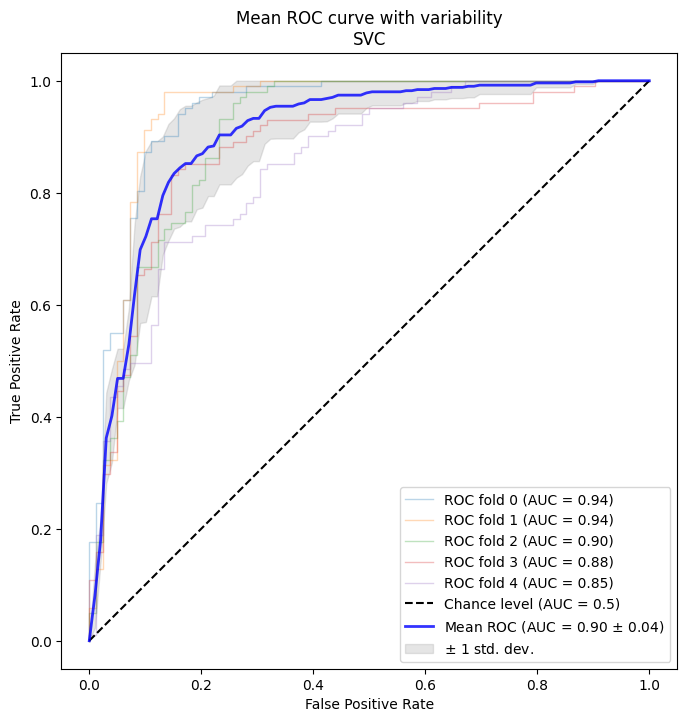

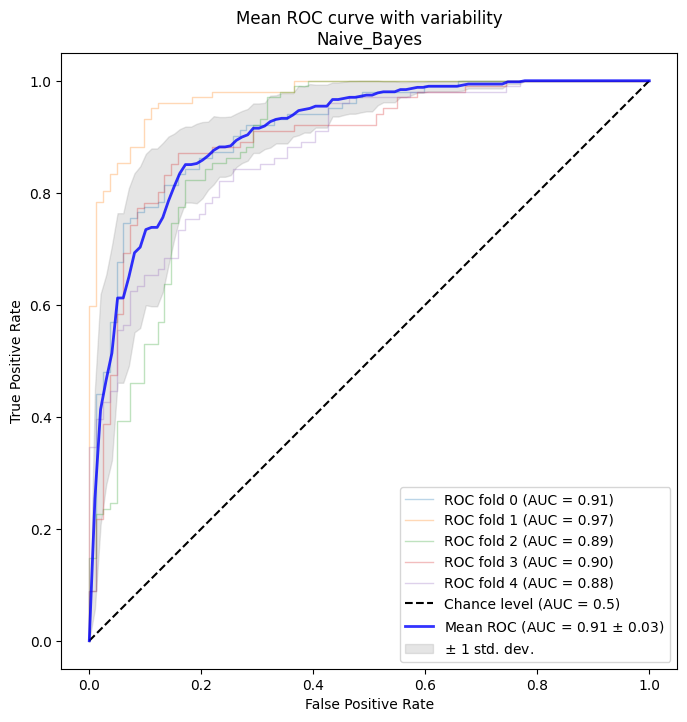

In [46]:
def plot_cv_roc(model_name):
    n_splits = 5

    cv = StratifiedKFold(n_splits=n_splits)

    classifier = models[model_name]

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(10, 8))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name=f'ROC fold {fold}',
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color='b',
        label=f'Mean ROC (AUC = {overall_mean_auc:.2f} ' +
        r'$\pm$ ' + f'{overall_std_auc:.3f})',
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color='grey',
        alpha=0.2,
        label=r'$\pm$ 1 std. dev.',
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel='False Positive Rate',
        ylabel='True Positive Rate',
        title=f'Mean ROC curve with variability\n{model_name}',
    )
    ax.axis('square')
    ax.legend(loc='lower right')
    plt.show()


for name, model in models.items():
    plot_cv_roc(name)

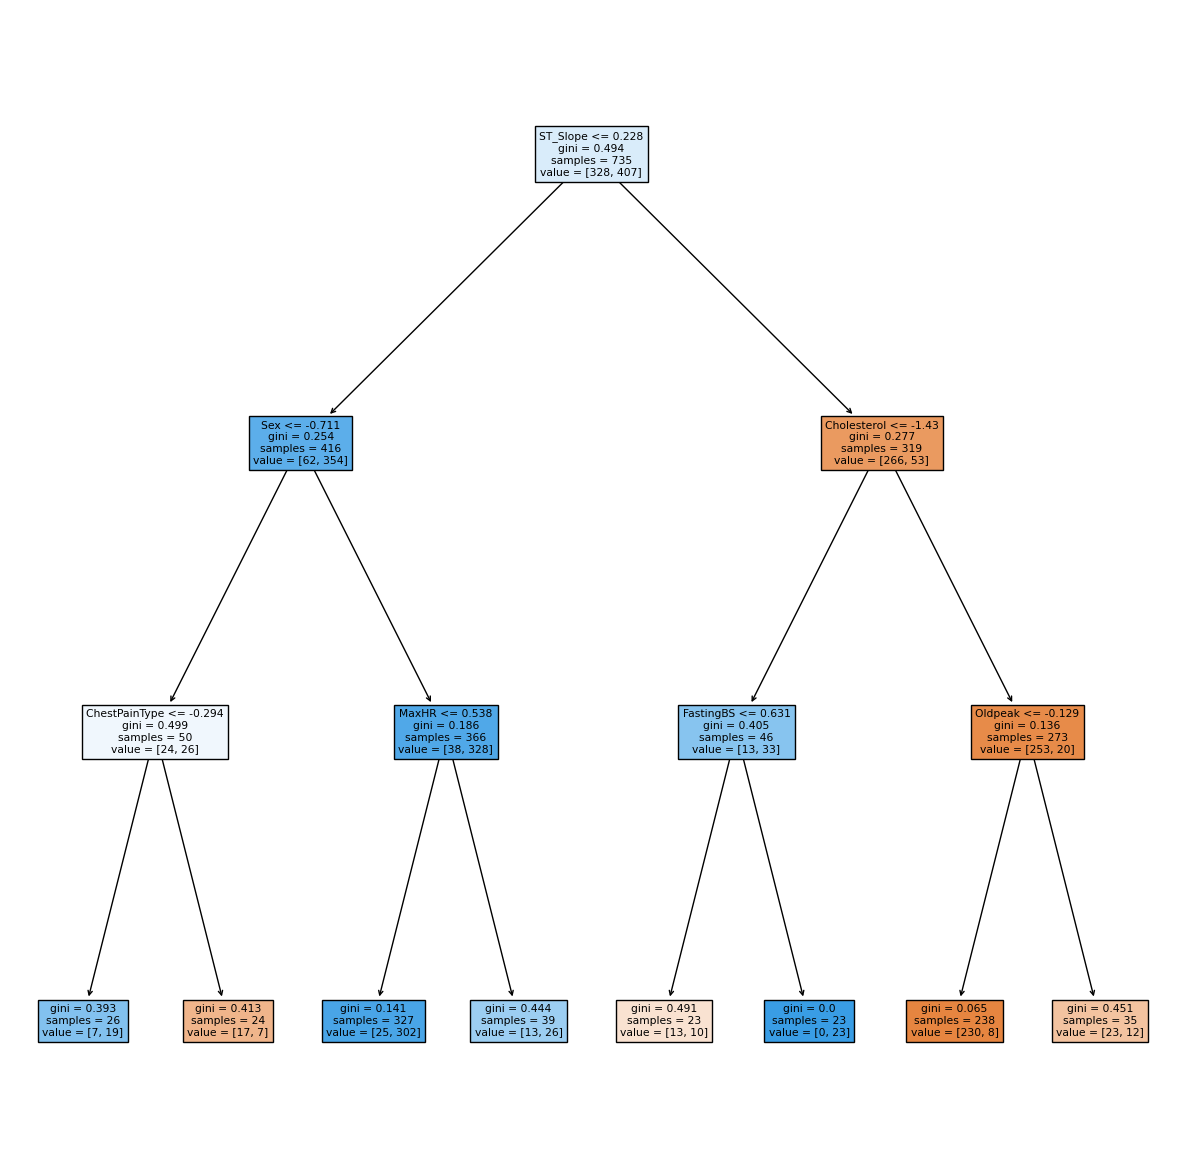

In [53]:
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=models['Decision_Tree'],
          feature_names=heart_data.columns, filled=True)

plt.show()